# Predicting Heart Disease

### Daniel Connolly

Data Science Spring 2019

[MIT License](https://en.wikipedia.org/wiki/MIT_License)

After starting work on several different datasets, ranging from data regarding superconductors to machine bias, I eventually decided to prioritize getting experience with machine learning. As a result, I found a challenge on DrivenData that afforded me the opportunity to try to predict heart disease using machine learning and chose to give it a go. This notebook begins with simple regression models and progresses into more advanced machine learning and neural networks.

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import Lasso, LogisticRegression
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
from keras.layers import Dense
from keras.models import Sequential
from sklearn.ensemble import RandomForestRegressor
import seaborn as sns
import statsmodels.formula.api as smf

Using TensorFlow backend.


Retrieve the data from the csv files provided by the Driven Data competition.

In [2]:
trainVal = pd.read_csv('train_values.csv')
trainLab = pd.read_csv('train_labels.csv')
testVal = pd.read_csv('test_values.csv')

In [3]:
trainVal.head()

,patient_id,slope_of_peak_exercise_st_segment,thal,resting_blood_pressure,chest_pain_type,num_major_vessels,fasting_blood_sugar_gt_120_mg_per_dl,resting_ekg_results,serum_cholesterol_mg_per_dl,oldpeak_eq_st_depression,sex,age,max_heart_rate_achieved,exercise_induced_angina
0,0z64un,1,normal,128,2,0,0,2,308,0.0,1,45,170,0
1,ryoo3j,2,normal,110,3,0,0,0,214,1.6,0,54,158,0
2,yt1s1x,1,normal,125,4,3,0,2,304,0.0,1,77,162,1
3,l2xjde,1,reversible_defect,152,4,0,0,0,223,0.0,1,40,181,0
4,oyt4ek,3,reversible_defect,178,1,0,0,2,270,4.2,1,59,145,0


In [4]:
cols = ['slope_of_peak_exercise_st_segment',
       'resting_blood_pressure', 'chest_pain_type', 'num_major_vessels',
           'serum_cholesterol_mg_per_dl', 'oldpeak_eq_st_depression', 'age',
       'max_heart_rate_achieved', 'resting_ekg_results', 'resting_ekg_results']

Standardize the columns in order to ensure variables are not weighted unfairly heavily over one another.

In [5]:
def std_cols(df, cols):
    for col in cols:
        df[col + '_std'] = (df[col] - df[col].mean())/df[col].std()
    return df
trainVal_std = std_cols(trainVal, cols)

Standardize the columns by gender as well. This will help in case there are significant differences between men and women.

In [6]:
def std_by_gender(df, cols):
    for col in cols:
        women = (df[df.sex == 0][col].mean(), df[df.sex == 0][col].std())
        men = (df[df.sex == 1][col].mean(), df[df.sex == 1][col].std())
        for i, row in df.iterrows():
            if row['sex'] == 0:
                df.at[i, col + '_std_sex'] = (row[col] - women[0])/women[1]
            else:
                df.at[i, col + '_std_sex'] = (row[col] - men[0])/men[1]
    return df
trainVal_std = std_by_gender(trainVal_std, cols)

In [7]:
trainLab.head()

,patient_id,heart_disease_present
0,0z64un,0
1,ryoo3j,0
2,yt1s1x,1
3,l2xjde,1
4,oyt4ek,0


In [8]:
combo = pd.merge(trainLab, trainVal_std, on='patient_id')

Upon initially looking through the data available to me, I figured that the max heart rate achieved variable likely had some positive predictive value for heart disease. As a result, I ran a logistic regression to investigate this.

In [9]:
model = smf.logit('heart_disease_present ~ max_heart_rate_achieved_std', data=combo)
fit = model.fit()
fit.summary()

Optimization terminated successfully.
         Current function value: 0.612784
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                             Logit Regression Results                            
=================================================================================
Dep. Variable:     heart_disease_present   No. Observations:                  180
Model:                             Logit   Df Residuals:                      178
Method:                              MLE   Df Model:                            1
Date:                   Mon, 29 Apr 2019   Pseudo R-squ.:                  0.1080
Time:                           23:58:30   Log-Likelihood:                -110.30
converged:                          True   LL-Null:                       -123.65
                                           LLR p-value:                 2.371e-07
===============================================================================================
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept                      -0.2431      0.162     -1.501      0.133      -0.561       0.074
max_heart_rate_achieved_std    -0.8470      0.179     -4.731      0.000      -1.198      -0.496
===============================================================================================
"""

With a pseudo R-squared of 0.108 and a negligible p value, it seems that there is a relationship between max heart rate and heart disease. Next, I break up the data into training and test sets and perform a similar logistic regression using sklearn.

In [10]:
y = combo[['patient_id','heart_disease_present']]
X = combo.drop('heart_disease_present', axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.5, random_state=42)

In [11]:
X= X_train['max_heart_rate_achieved_std']
y= y_train['heart_disease_present']
xarr = np.array(X)
yarr = np.array(y)
xarr = xarr.reshape((xarr.shape[0], 1))

In [12]:
lr = LogisticRegression(random_state=0, solver='lbfgs',multi_class='multinomial').fit(xarr, yarr)
t1 = np.array(X_test['max_heart_rate_achieved_std'])
t1 = t1.reshape((t1.shape[0], 1))
y1 = np.array(y_test['heart_disease_present'])
lr.score(t1,y1)

0.6333333333333333

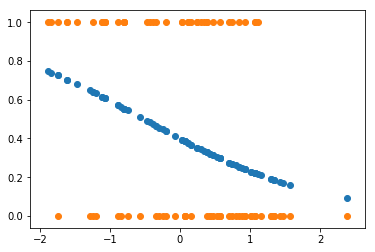

In [13]:
plt.scatter(t1, lr.predict_proba(t1)[:,1])
plt.scatter(t1, y1)

59% is a good score for a first trail run. Now let's run it with the standardized age of the study participants and see how the result changes.

In [14]:
X= X_train[['max_heart_rate_achieved_std', 'age_std']]
y= y_train['heart_disease_present']
xarr = np.array(X)
yarr = np.array(y)
xarr = xarr.reshape((xarr.shape[0], 2))

In [15]:
lr = LogisticRegression(random_state=0, solver='lbfgs',multi_class='multinomial').fit(xarr, yarr)
t1 = np.array(X_test[['max_heart_rate_achieved_std','age_std']])
t1 = t1.reshape((t1.shape[0], 2))
y1 = np.array(y_test['heart_disease_present'])
lr.score(t1,y1)

0.6

The score dropped, which likely means the standardized age is not a particularly strong predictor of heart disease.

Rather than run this type of test with every variable, let's perform Lasso regression to see if any of the variables are particularly good indicators of heart disease.

In [16]:
std_cols = ['slope_of_peak_exercise_st_segment_std',
       'resting_blood_pressure_std', 'chest_pain_type_std', 'num_major_vessels_std',
           'serum_cholesterol_mg_per_dl_std', 'oldpeak_eq_st_depression_std', 'age_std',
       'max_heart_rate_achieved_std', 'resting_ekg_results_std', 'resting_ekg_results_std', 'heart_disease_present', 'patient_id']
df_std = combo[std_cols]
df_std.head()

,slope_of_peak_exercise_st_segment_std,resting_blood_pressure_std,chest_pain_type_std,num_major_vessels_std,serum_cholesterol_mg_per_dl_std,oldpeak_eq_st_depression_std,age_std,max_heart_rate_achieved_std,resting_ekg_results_std,resting_ekg_results_std,heart_disease_present,patient_id
0,-0.888762,-0.194652,-1.231340,-0.716404,1.115158,-0.900694,-1.051032,0.929891,0.951196,0.951196,0,0z64un
1,0.727169,-1.252825,-0.165757,-0.716404,-0.667915,0.526148,-0.086892,0.386007,-1.051322,-1.051322,0,ryoo3j
2,-0.888762,-0.371014,0.899825,2.378462,1.039283,-0.900694,2.377024,0.567302,0.951196,0.951196,1,yt1s1x
3,-0.888762,1.216246,0.899825,-0.716404,-0.497195,-0.900694,-1.586666,1.428452,-1.051322,-1.051322,1,l2xjde
4,2.343100,2.744719,-2.296923,-0.716404,0.394342,2.844768,0.448742,-0.203201,0.951196,0.951196,0,oyt4ek


In [17]:
y = df_std[['patient_id','heart_disease_present']]
X = df_std.drop('heart_disease_present', axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.3, random_state=42)

In [18]:
y_train= y_train['heart_disease_present']
X_train= X_train.drop('patient_id', axis=1)

lasso = Lasso(alpha=0.1, normalize=True)
lasso.fit(X_train, y_train)

Lasso(alpha=0.1, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=True, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)

In [19]:
lasso_pred = lasso.predict(X_test.drop('patient_id', axis=1))
lasso.score(X_test.drop('patient_id', axis=1), y_test['heart_disease_present'])

-0.07037297677691745

In [20]:
coef = lasso.coef_
names = X_train.columns
print(coef)

[ 0.  0.  0.  0.  0.  0.  0. -0.  0.  0.]


Lasso regression doesn't appear to have worked. We can try Random Forest Regression instead.

In [21]:
y = df_std[['patient_id','heart_disease_present']]
X = df_std.drop('heart_disease_present', axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.3, random_state=42)
y_train= y_train['heart_disease_present']
X_train= X_train.drop('patient_id', axis=1)

In [22]:
regr = RandomForestRegressor(max_depth=2,random_state=0,n_estimators=100)
regr.fit(X_train,y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=2,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
           oob_score=False, random_state=0, verbose=0, warm_start=False)

In [23]:
y_test = y_test['heart_disease_present']
X_test = X_test.drop('patient_id', axis=1)
regr.score(X_test, y_test)

0.26801260182616793

Perhaps the out of the box random forest regression is not particularly accurate, but we can still use it to extract the relative importance of variables in the dataset.

In [24]:
imp = regr.feature_importances_

Below, a simple function for extracting the important features from the dataset based on the regression results.

In [25]:
def get_feats(df, importance):
    ll = dict()
    for i in range(len(df.columns[:10])):
        if (importance[i] > 0):
            ll[df.columns[i]] = importance[i]
    return ll

In [26]:
get_feats(df_std, imp)

{'slope_of_peak_exercise_st_segment_std': 0.11214545673963995,
 'resting_blood_pressure_std': 0.016422137096473603,
 'chest_pain_type_std': 0.19729248585168416,
 'num_major_vessels_std': 0.21579927808583946,
 'serum_cholesterol_mg_per_dl_std': 0.047439136964833845,
 'oldpeak_eq_st_depression_std': 0.27992066021349726,
 'age_std': 0.03940803487926289,
 'max_heart_rate_achieved_std': 0.08619181717642264,
 'resting_ekg_results_std': 0.003434675393637947}

It appears the most important two features are the STdepression induced by exercise relative to rest (oldpeak_eq_st_depression_std) and the the number of major vessels colored by fluorosopy (like a continuous X-ray image on a monitor) (num_major_vessels_std), followed by the chest pain type.

We'll try a logistic regression with the two most important of those variables.

In [27]:
y = df_std[['patient_id','heart_disease_present']]
X = df_std.drop('heart_disease_present', axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.3, random_state=42)

In [28]:
X= X_train[['oldpeak_eq_st_depression_std', 'num_major_vessels_std']]
y= y_train['heart_disease_present']
xarr = np.array(X)
yarr = np.array(y)
xarr = xarr.reshape((xarr.shape[0], 2))

In [29]:
lr = LogisticRegression(random_state=0, solver='lbfgs',multi_class='multinomial').fit(xarr, yarr)
t1 = np.array(X_test[['oldpeak_eq_st_depression_std', 'num_major_vessels_std']])
t1 = t1.reshape((t1.shape[0], 2))
y1 = np.array(y_test['heart_disease_present'])
lr.score(t1,y1)

0.7037037037037037

A score of 70% is better than before. Below, I visualize the decision boundary of this logistic regression.

In [30]:
xx, yy = np.mgrid[-3:3:.01, -3:3:.01]
grid = np.c_[xx.ravel(), yy.ravel()]
probs = lr.predict_proba(grid)[:, 1].reshape(xx.shape)

[(-3, 3),
 Text(0, 0.5, '$Standardized Number of Major Vessles on Fluorosopy$'),
 (-3, 3),
 Text(0.5, 0, '$Standardized ST Depression$'),
 None]

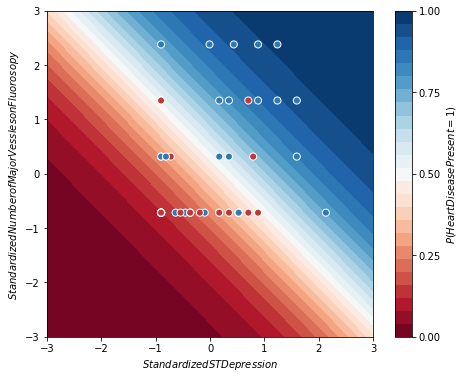

In [31]:
f, ax = plt.subplots(figsize=(8, 6))
contour = ax.contourf(xx, yy, probs, 25, cmap="RdBu",
                      vmin=0, vmax=1)
ax_c = f.colorbar(contour)
ax_c.set_label("$P(Heart Disease Present = 1)$")
ax_c.set_ticks([0, .25, .5, .75, 1])

ax.scatter(t1[:,0], t1[:, 1], c=y1[:], s=50,
           cmap="RdBu", vmin=-.2, vmax=1.2,
           edgecolor="white", linewidth=1)

ax.set(aspect="equal",
       xlim=(-3, 3), ylim=(-3, 3),
       xlabel="$Standardized ST Depression$", ylabel="$Standardized Number of Major Vessles on Fluorosopy$")

The regression is not working perfectly, but the decision barrier makes it visually clear that the majority of the model's predictions are accurate. The difference would likely be more obvious if there were more data points.

Next, we'll add one variable and plot the ROC curve.

In [32]:
y = df_std[['patient_id','heart_disease_present']]
X = df_std.drop('heart_disease_present', axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.3, random_state=42)

In [33]:
X= X_train[['oldpeak_eq_st_depression_std', 'num_major_vessels_std','chest_pain_type_std']]
y= y_train['heart_disease_present']
xarr = np.array(X)
yarr = np.array(y)
xarr = xarr.reshape((xarr.shape[0], 3))

In [34]:
lr = LogisticRegression(random_state=0, solver='lbfgs',multi_class='multinomial').fit(xarr, yarr)
t1 = np.array(X_test[['oldpeak_eq_st_depression_std', 'num_major_vessels_std', 'chest_pain_type_std']])
t1 = t1.reshape((t1.shape[0], 3))
y1 = np.array(y_test['heart_disease_present'])
lr.score(t1,y1)

0.7407407407407407

At 74%, this is a decent model, which may be worth submitting to DrivenData. Below, I use the model to make predictions on the test data provided by the competition.

In [35]:
cols = ['slope_of_peak_exercise_st_segment',
       'resting_blood_pressure', 'chest_pain_type', 'num_major_vessels',
           'serum_cholesterol_mg_per_dl', 'oldpeak_eq_st_depression', 'age',
       'max_heart_rate_achieved', 'resting_ekg_results', 'resting_ekg_results']

In [36]:
#Redefining this here to avoid error
def std_cols(df, cols):
    for col in cols:
        df[col + '_std'] = (df[col] - df[col].mean())/df[col].std()
    return df

In [37]:
testval_std = std_cols(testVal, cols)
tests = np.array(testval_std[['oldpeak_eq_st_depression_std', 'num_major_vessels_std', 'chest_pain_type_std']])
tests = tests.reshape((tests.shape[0],3))
pred_prob = lr.predict_proba(tests)[:,1]
df = pd.DataFrame()
df['patient_id'] = testVal['patient_id']
df['heart_disease_present'] = pred_prob
df.head()

,patient_id,heart_disease_present
0,olalu7,0.015318
1,z9n6mx,0.489257
2,5k4413,0.756969
3,mrg7q5,0.187507
4,uki4do,0.965686


In [38]:
df.to_csv('submission1.csv', index=False)

The above model scored in the top 25% percent of the competition, which has nearly 2000 participants.

In [39]:
from sklearn.metrics import roc_curve
y_pred_prob = lr.predict_proba(t1)[:,1]
fpr, tpr, thresholds = roc_curve(y1, y_pred_prob)

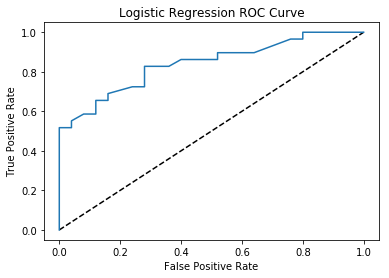

In [40]:
plt.plot([0,1],[0,1], 'k--')
plt.plot(fpr, tpr, label='Logistic Regression')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Logistic Regression ROC Curve')
plt.show()

The ROC curve above indicates the test is working well, but not perfectly.

In [41]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y1, y_pred_prob)

0.8400000000000001

Again, 0.84 indicates good, but not excellent, classification.

In [42]:
from sklearn.model_selection import cross_val_score
cross_val_score(lr, X, y, cv=5, scoring='roc_auc')

array([0.80606061, 0.90666667, 0.86666667, 0.87666667, 0.89333333])

Above, five-fold cross validation on the ROC-AUC score found before. On average, these scores indicate the model performs even better than previously indicated.

Before moving on to more advance models, it may help to further visualize some of the relationships between variables in the dataset.

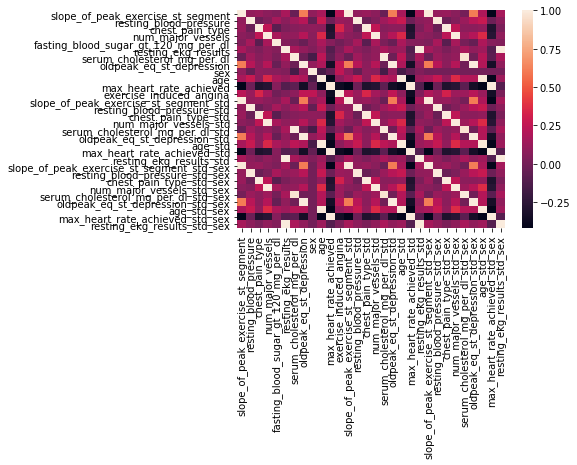

In [43]:
corr = trainVal.corr()
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns)

Perhaps the most notable thing about this correlation matrix is that there is a correlation between the slope of an ST segment at the peak of exercisse and the ST depression. This isn't particularly surpring, however, because both involve the ST segment. For more information on the ST segment, click [here](https://en.wikipedia.org/wiki/ST_segment).

/home/dconnolly/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


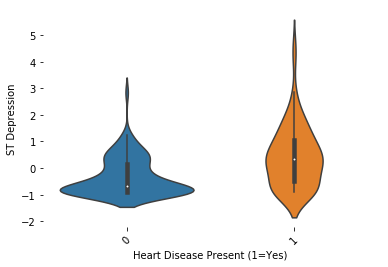

In [44]:
data = df_std.dropna(subset=['oldpeak_eq_st_depression_std', 'heart_disease_present'])
sns.violinplot(x='heart_disease_present', y='oldpeak_eq_st_depression_std', data=data, whis=10)
sns.set(style="whitegrid", palette="pastel", color_codes=True)


sns.despine(left=True, bottom=True)
plt.xticks(rotation=45)
plt.xlabel('Heart Disease Present (1=Yes)')
plt.ylabel('ST Depression');

Text(0.5, 0, 'Heart Disease Present (1=Yes)')

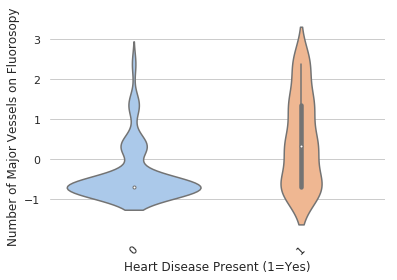

In [45]:
data = df_std.dropna(subset=['num_major_vessels_std', 'heart_disease_present'])
sns.violinplot(x='heart_disease_present', y='num_major_vessels_std', data=data, whis=10)
sns.set(style="whitegrid", palette="pastel", color_codes=True)


sns.despine(left=True, bottom=True)
plt.xticks(rotation=45)
plt.ylabel('Number of Major Vessels on Fluorosopy')
plt.xlabel('Heart Disease Present (1=Yes)')

The violin plot above tells us that those without heart disease tend to have fewer blood vessels show up on the fluorosopy involved during data collection.

Text(0.5, 0, 'Heart Disease Present (1=Yes)')

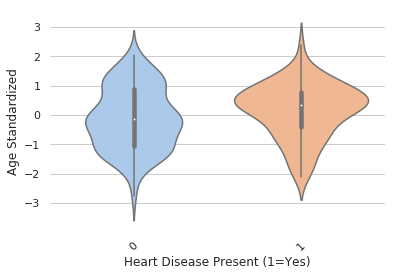

In [46]:
data = df_std.dropna(subset=['age_std', 'heart_disease_present'])
sns.violinplot(x='heart_disease_present', y='age_std', data=data, whis=10)
sns.set(style="whitegrid", palette="pastel", color_codes=True)


sns.despine(left=True, bottom=True)
plt.xticks(rotation=45)
plt.ylabel('Age Standardized')
plt.xlabel('Heart Disease Present (1=Yes)')

The plot above shows that heart disease tends to occur in the older population.

Text(0.5, 0, 'Heart Disease Present (1=Yes)')

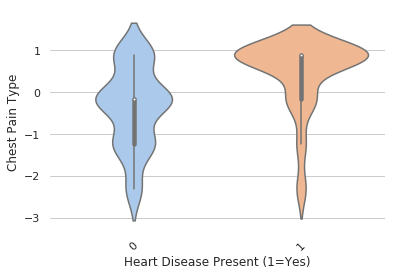

In [47]:
data = df_std.dropna(subset=['chest_pain_type_std', 'heart_disease_present'])
sns.violinplot(x='heart_disease_present', y='chest_pain_type_std', data=data, whis=10)
sns.set(style="whitegrid", palette="pastel", color_codes=True)


sns.despine(left=True, bottom=True)
plt.xticks(rotation=45)
plt.ylabel('Chest Pain Type')
plt.xlabel('Heart Disease Present (1=Yes)')

Chest pain types were coded from 1-4 in the original dataset, with the values as follows:

            Value 1: typical angina
        
            Value 2: atypical angina
        
            Value 3: non-anginal pain
        
            Value 4: asymptomatic

The plot above indicated that those with heart disease tended to report being asymptomatic at a higher rate. This is very, very counterintuitive. I've checked the dataset several times to make sure this is correct, and it seems to be; it just doesn't make much intuitive sense. 

Text(0.5, 0, 'Heart Disease Present (1=Yes)')

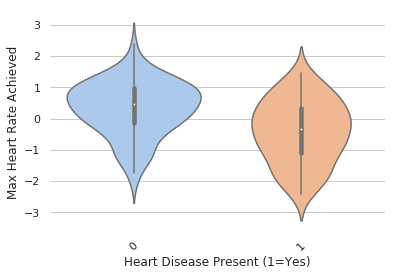

In [48]:
data = df_std.dropna(subset=['max_heart_rate_achieved_std', 'heart_disease_present'])
sns.violinplot(x='heart_disease_present', y='max_heart_rate_achieved_std', data=data, whis=10)
sns.set(style="whitegrid", palette="pastel", color_codes=True)


sns.despine(left=True, bottom=True)
plt.xticks(rotation=45)
plt.ylabel('Max Heart Rate Achieved')
plt.xlabel('Heart Disease Present (1=Yes)')

The plot above indicates that those who are able to reach a higher max heart rate are less likely to have heart disease.

We will run one more logistic regression with the three most important features in the dataset as obtained by the random forest regression I ran earlier.

In [49]:
model = smf.logit('heart_disease_present ~ chest_pain_type_std + num_major_vessels_std + oldpeak_eq_st_depression_std', data=combo)
fit = model.fit()
fit.summary()

Optimization terminated successfully.
         Current function value: 0.460299
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                             Logit Regression Results                            
=================================================================================
Dep. Variable:     heart_disease_present   No. Observations:                  180
Model:                             Logit   Df Residuals:                      176
Method:                              MLE   Df Model:                            3
Date:                   Mon, 29 Apr 2019   Pseudo R-squ.:                  0.3299
Time:                           23:58:32   Log-Likelihood:                -82.854
converged:                          True   LL-Null:                       -123.65
                                           LLR p-value:                 1.393e-17
================================================================================================
                                   coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept                       -0.2066      0.196     -1.052      0.293      -0.592       0.178
chest_pain_type_std              0.9876      0.218      4.520      0.000       0.559       1.416
num_major_vessels_std            0.8962      0.230      3.897      0.000       0.446       1.347
oldpeak_eq_st_depression_std     1.0797      0.244      4.425      0.000       0.601       1.558
================================================================================================
"""

With a pseudo r-squared of 0.329, and negligible p-values for all variables included in the model, this seems to be a fairly predictive combination. To confirm that there wasn't an error where every variable was giving me a p value of 0, I ran the logistic model below.

In [50]:
model = smf.logit('heart_disease_present ~ age_std_sex + chest_pain_type_std + num_major_vessels_std + oldpeak_eq_st_depression_std', data=combo)
fit = model.fit()
fit.summary()

Optimization terminated successfully.
         Current function value: 0.459974
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                             Logit Regression Results                            
=================================================================================
Dep. Variable:     heart_disease_present   No. Observations:                  180
Model:                             Logit   Df Residuals:                      175
Method:                              MLE   Df Model:                            4
Date:                   Mon, 29 Apr 2019   Pseudo R-squ.:                  0.3304
Time:                           23:58:32   Log-Likelihood:                -82.795
converged:                          True   LL-Null:                       -123.65
                                           LLR p-value:                 7.542e-17
================================================================================================
                                   coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept                       -0.2017      0.197     -1.023      0.306      -0.588       0.185
age_std_sex                     -0.0718      0.210     -0.341      0.733      -0.484       0.340
chest_pain_type_std              0.9886      0.219      4.521      0.000       0.560       1.417
num_major_vessels_std            0.9232      0.245      3.770      0.000       0.443       1.403
oldpeak_eq_st_depression_std     1.0939      0.248      4.415      0.000       0.608       1.580
================================================================================================
"""

It appears that the added variable does not have much statistical significance.

Now, let's see how a neural network stacks up against that competition.

In [51]:
y = df_std[['patient_id','heart_disease_present']]
X = df_std.drop('heart_disease_present', axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2, random_state=42)

In [52]:
X_train.columns

Index(['slope_of_peak_exercise_st_segment_std', 'resting_blood_pressure_std',
       'chest_pain_type_std', 'num_major_vessels_std',
       'serum_cholesterol_mg_per_dl_std', 'oldpeak_eq_st_depression_std',
       'age_std', 'max_heart_rate_achieved_std', 'resting_ekg_results_std',
       'resting_ekg_results_std', 'patient_id'],
      dtype='object')

In [53]:
y = df_std['heart_disease_present']
X = df_std.drop('heart_disease_present', axis=1)
n_cols = X.drop('patient_id', axis=1).shape[1]
# n_cols = h.shape[1]
# print(X_train['patient_id'].)
# print(n_cols)
model = Sequential()
model.add(Dense(100, activation='relu', input_shape = (n_cols,)))
model.add(Dense(100, activation='relu'))
model.add(Dense(100, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='binary_crossentropy',metrics=['accuracy'])
mod = model.fit(X.drop('patient_id', axis=1), y, validation_split=0.3, epochs=10,verbose=1)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Train on 125 samples, validate on 55 samples
Epoch 1/10
125/125 [==============================] - 0s 2ms/step - loss: 6.7053 - acc: 0.5600 - val_loss: 8.2056 - val_acc: 0.3636
Epoch 2/10
125/125 [==============================] - 0s 54us/step - loss: 6.7051 - acc: 0.4080 - val_loss: 8.2056 - val_acc: 0.2364
Epoch 3/10
125/125 [==============================] - 0s 66us/step - loss: 6.7051 - acc: 0.1840 - val_loss: 8.2056 - val_acc: 0.1636
Epoch 4/10
125/125 [==============================] - 0s 58us/step - loss: 6.7051 - acc: 0.1200 - val_loss: 8.2056 - val_acc: 0.0727
Epoch 5/10
125/125 [==============================] - 0s 80us/step - loss: 6.7051 - acc: 0.0880 - val_loss: 8.2056 - val_acc: 0.0545
Epoch 6/10
125/125 [==============================] - 0s 73us/step - loss: 6.7051 - acc: 0.0640 - val_loss: 8.2056 - val_acc: 0.0364
Epoch 7/10
125/125 [==================

To align with the test statistic of the DrivenData competition, I use the binary cross-entropy flag, which is essentially the same as the log loss function.

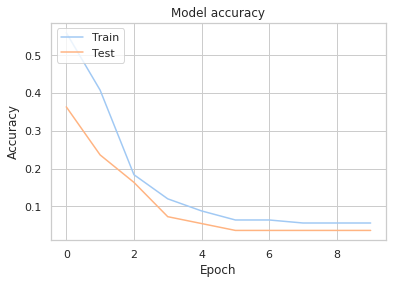

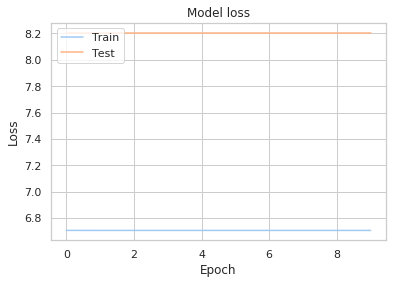

In [54]:
# Plot training & validation accuracy values
plt.plot(mod.history['acc'])
plt.plot(mod.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(mod.history['loss'])
plt.plot(mod.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()


On the whole, it does not seem that this neural network model performs particularly well on this dataset.